In [5]:
from sentence_transformers import SentenceTransformer
import torch
import faiss
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt


### Helper functions

In [6]:
def get_data_frame_from_csv(file_path):
    """
    This function is used to create and return the data frame from csv file
    parameters: file_path
    return: Panda data frame
    """
    return pd.read_csv(file_path)
def get_final_answer_data_frame(df, group_by_col_name,concate_col_name):
    """_summary_

    Args:
        df (_type_): _description_
        group_by_col_name (_type_): _description_
        concate_col_name (_type_): _description_

    Returns:
        _type_: _description_
    """
    return df.groupby(group_by_col_name)[concate_col_name].agg(lambda x: " ".join(x)).reset_index()
def get_llm_details():
    """_summary_

    Returns:
        _type_: _description_
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")
    return model
def get_embedding(text_data,model):
    """
    This model used for creating embeddings of text data

    Args:
        text_data (List): List of text
        model (Sentence Transforme): Sentence Transformer model

    Returns:
        Sentence transformer: Instance of Sentence transformer
    """
    return model.encode(text_data, convert_to_numpy=True)

def get_embedding_dimention(df,embedding_column):
    """
    Get embedding dimention

    Args:
        df (Pandas Data frame): Pandas Data frame
        embedding_column (String): Embedding Column name

    Returns:
        int: Return number of row
    """
    return df[embedding_column].iloc[0].shape[0]

def recommend_exhibitors(answer_text,df):
    """
    This function return the recommend exhibitor name
    Args:
        answer_text (string): Answer text
        df (Pandas data frame): Pandas data frame

    Returns:
        List: Return the list of exhibitor name
    """
    # Create embedding  for answer text
    answer_embedding = get_embedding([answer_text], model)[0]
    # get the distance and index from vector db
    distances, indices = vdb_index_exhibitors.search(np.array([answer_embedding]), k=5)
    # get recommendation data frame using matching indices
    recommendations = df.iloc[indices[0]][["exhibitorid", "Name", "categoryName"]]
    return recommendations["Name"].to_list()

def hybrid_recommendation(answer_text, alpha=0.5):
    """
    This function return the recommendation from tfidf vectorization and semantic search recommendation

    Args:
        answer_text (String): Answer text
        alpha (float, optional): This alpha value used to control the recommendation contributation from Nearest neghbour model. Defaults to 0.5.

    Returns:
        List: List of exhibitor on the basis of answer
    """
    # Answer tf-idf vector using the answer text
    answer_tf_vector = tfidf.transform([answer_text])
    
    # Distance and index on the basis exhibitor knn model
    distances, indices = exhibitor_knn_model.kneighbors(answer_tf_vector)
    scores = 1 - distances  # Convert distances to similarity scores
    # Recommenndation of exibitor data frame using indices
    recommendations_tfidf = exhibitor_df_final.iloc[indices[0]][['exhibitorid', 'Name', 'categoryName']]
    # Add score featire using alpha value
    recommendations_tfidf['score'] = alpha * scores.flatten()
    
    # vdb-based Recommendations
    vdb_distances, vdb_indices = vdb_index.search(answer_tf_vector.toarray(), 5)
    vdb_scores = 1 / (1 + vdb_distances)  # Convert L2 distances to similarity scores
    vdb_recommendations = exhibitor_df_final.iloc[vdb_indices[0]][['exhibitorid', 'Name', 'categoryName']]
    vdb_recommendations['score'] = (1 - alpha) * vdb_scores.flatten()
    
    # Combine and Rank Recommendations
    final_recommendations = pd.concat([recommendations_tfidf, vdb_recommendations])
    final_recommendations = final_recommendations.groupby(['exhibitorid', 'Name', 'categoryName']).sum().reset_index()
    final_recommendations = final_recommendations.sort_values(by='score', ascending=False)
    
    return list(set(final_recommendations.head(10)["Name"].to_list()))  # Return top 5 recommendations



In [7]:
visitor_df = get_data_frame_from_csv("../../source/clean_visitor_data.csv")
visitor_df.head()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,email,gender,id,stepId,questionId,answerValue,answerId,answerTypeId,questionTypeId,question,answer,stepId_int
0,emilija+100_L8gA@bss.mk,F,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f730fd,5c8a78336d41a10da4f730fe,NaN,5c8a78336d41a10da4f73100,Answer,5bf7c399b82beb7a182cc3de,Reason for Attending the Event,To obtain general information,1
1,emilija+100_L8gA@bss.mk,F,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f73225,5c8a78336d41a10da4f73227,NaN,5c8a78336d41a10da4f73244,Answer,5bf7c399b82beb7a182cc3de,Which of the following best describes your job...,Media,2
2,emilija+100_L8gA@bss.mk,F,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f73252,5c8a78336d41a10da4f73253,NaN,5c8a78336d41a10da4f73291,Answer,5bf7c399b82beb7a182cc3de,Please indicate your company's main area of bu...,Travel Agent,3
3,emilija+100_L8gA@bss.mk,F,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f7336c,5c8a78336d41a10da4f7336d,NaN,5c8a78336d41a10da4f73371,Answer,5bf7c399b82beb7a182cc3de,What role do you play in the purchasing decisi...,No influence,4
4,aleksandar.dimkov+mitt1_n5eA@bss.com.mk,M,67ada1ee197e604dd2722d1b,5c8a78336d41a10da4f730fd,5c8a78336d41a10da4f730fe,NaN,5c8a78336d41a10da4f730ff,Answer,5bf7c399b82beb7a182cc3de,Reason for Attending the Event,To source products and services,1


In [8]:
visitor_df_final = get_final_answer_data_frame(visitor_df, "email","answer").head()
visitor_df_final["answer"] = visitor_df_final["answer"].apply(lambda x : x.lower().replace("unknown"," "))
visitor_df_final.head()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,email,answer
0,3990147_SeNs@gmail.com,to source products and services tour operato...
1,3990147_SeNs_09Hr@gmail.com,to source products and services tour operato...
2,3990147_SeNs_mVZi@gmail.com,to source products and services tour operato...
3,aleksandar.dimkov+mb1_Xc8j@bss.com.mk,to obtain general information sales event mana...
4,aleksandar.dimkov+mb1_Xc8j_kuh8@bss.com.mk,to obtain general information sales event mana...


In [9]:
exhibitor_df = get_data_frame_from_csv("../../source/clean_exhibitor.csv")
exhibitor_df.head()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Unnamed: 0,exhibitorid,Name,categoryId,categoryName
0,0,90556,Turkey Travels,52276,1.5 Resort hotel
1,1,90556,Turkey Travels,52280,2.1 Inbound tour operator
2,2,90556,Turkey Travels,52281,2.2 Outbound tour operator
3,3,92462,Russian Travel Company,52273,1.2 Apartments Residential hotel
4,4,92462,Russian Travel Company,52283,2.4 Mass market tour operators


In [10]:
model = get_llm_details()

In [11]:
# Exhibitor category and name embedding
exhibitor_df["categoryName"] = exhibitor_df["categoryName"].apply(lambda x: x.lower())
exhibitor_df["Name"] = exhibitor_df["Name"].apply(lambda x: x.lower())
exhibitor_cat_name = exhibitor_df["categoryName"] + " " + exhibitor_df["Name"]
exhibitor_df_final = exhibitor_df.copy()
exhibitor_df_final["name_cat_embedding"] = list(get_embedding(exhibitor_cat_name.tolist(),model))

In [12]:
visitor_danswer = visitor_df_final.groupby("email")["answer"].apply(lambda x: " ".join(x)).reset_index()
visitor_danswer["answer_embedding"] = list(get_embedding(visitor_danswer["answer"].tolist(), model))


In [13]:
# Create vdb Index for Exhibitors
vdb_index_exhibitors = faiss.IndexFlatL2(get_embedding_dimention(exhibitor_df_final,"name_cat_embedding"))
vdb_index_exhibitors.add(np.array(exhibitor_df_final["name_cat_embedding"].tolist()))

# Create vdb Index for Visitors
vdb_index_visitors = faiss.IndexFlatL2(get_embedding_dimention(visitor_danswer,"answer_embedding"))
vdb_index_visitors.add(np.array(visitor_danswer["answer_embedding"].tolist()))

In [14]:
recommend_exhibitors("To source products and services",exhibitor_df_final)

['elite travel services',
 'dream getaways expeditions',
 'dreamtravel company ',
 'global tours voyages',
 'exotic tours journeys']

### Hybrid Model for recommendations
- Use TF-IDF vectorizer to encode the text 
- Use Sentence tranformer embedding and Vector db for semantic search

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [16]:
tfidf = TfidfVectorizer(stop_words='english')

In [17]:
visitor_tfidf = tfidf.fit_transform(visitor_df_final["answer"])
exhibitor_tfidf = tfidf.transform(exhibitor_cat_name)

In [18]:
exhibitor_knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
exhibitor_knn_model.fit(exhibitor_tfidf)

visitor_knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
visitor_knn_model.fit(visitor_tfidf)

NearestNeighbors(metric='cosine')

In [19]:
vdb_index = faiss.IndexFlatL2(visitor_tfidf.shape[1])
vdb_index.add(visitor_tfidf.toarray())

In [20]:
hybrid_recommendation("To source products and services")

['dreamtravel company ',
 'turkey travels',
 'elite travel services',
 'russian travel company',
 'global tours voyages']

### Advanced Insights
- Predictive Analysis: Based on visitor preferences, predict what new categories should be introduced for exhibitors.
- Cluster Analysis: Segment visitors into different groups based on their answers and analyze their distinct characteristics.

In [21]:
# pip install wordcloud gensim

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import GridSearchCV


In [23]:
visitor_tfidf = tfidf.fit_transform(visitor_df_final["answer"])
exhibitor_tfidf = tfidf.transform(exhibitor_cat_name)

In [38]:
param = {'n_components': [3, 5, 7, 10]}
grid_search_cv = GridSearchCV(LatentDirichletAllocation(random_state=42), param, cv=3)
grid_search_cv.fit(visitor_tfidf)
best_lda = grid_search_cv.best_estimator_

In [39]:
topic_distributions = best_lda.fit_transform(visitor_tfidf)

In [40]:
# Display top words per topic
def display_topics(model, feature_names, num_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}: ", " ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

display_topics(best_lda, tfidf.get_feature_names_out())

Topic 1:  products source operator services influence tour sales role obtain management
Topic 2:  sales obtain information general event role management advisory tour source
Topic 3:  tour operator influence services source products management sales role obtain


In [41]:
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
# Convert TF-IDF matrix to list of words for Gensim
words = [text.split() for text in visitor_df_final['answer']]
dictionary = Dictionary(words)
corpus = [dictionary.doc2bow(text) for text in words]

# Train LDA using Gensim
num_topics = 5  # Choose optimal number based on your analysis
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15, random_state=42)

# Display top words per topic
def display_gensim_topics(model, num_words=10):
    for idx, topic in model.print_topics(num_words=num_words):
        print(f"Topic {idx+1}: {topic}")

display_gensim_topics(lda_model)

# Compute Coherence Score using Gensim LDA
lda_coherence = CoherenceModel(model=lda_model, texts=words, dictionary=dictionary, coherence='c_v')
print("LDA Coherence Score:", lda_coherence.get_coherence())

Topic 1: 0.059*"to" + 0.059*"services" + 0.059*"and" + 0.059*"products" + 0.059*"tour" + 0.059*"source" + 0.059*"operator" + 0.059*"no" + 0.059*"influence" + 0.059*"role"
Topic 2: 0.103*"to" + 0.103*"advisory" + 0.103*"sales" + 0.103*"information" + 0.103*"event" + 0.103*"obtain" + 0.103*"management" + 0.103*"role" + 0.103*"general" + 0.009*"tour"
Topic 3: 0.059*"to" + 0.059*"tour" + 0.059*"and" + 0.059*"source" + 0.059*"operator" + 0.059*"influence" + 0.059*"no" + 0.059*"services" + 0.059*"products" + 0.059*"general"
Topic 4: 0.059*"to" + 0.059*"influence" + 0.059*"no" + 0.059*"operator" + 0.059*"tour" + 0.059*"source" + 0.059*"products" + 0.059*"and" + 0.059*"services" + 0.059*"general"
Topic 5: 0.105*"influence" + 0.105*"source" + 0.105*"services" + 0.105*"products" + 0.105*"operator" + 0.105*"no" + 0.105*"and" + 0.105*"tour" + 0.105*"to" + 0.007*"management"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LDA Coherence Score: 0.05179002656735784


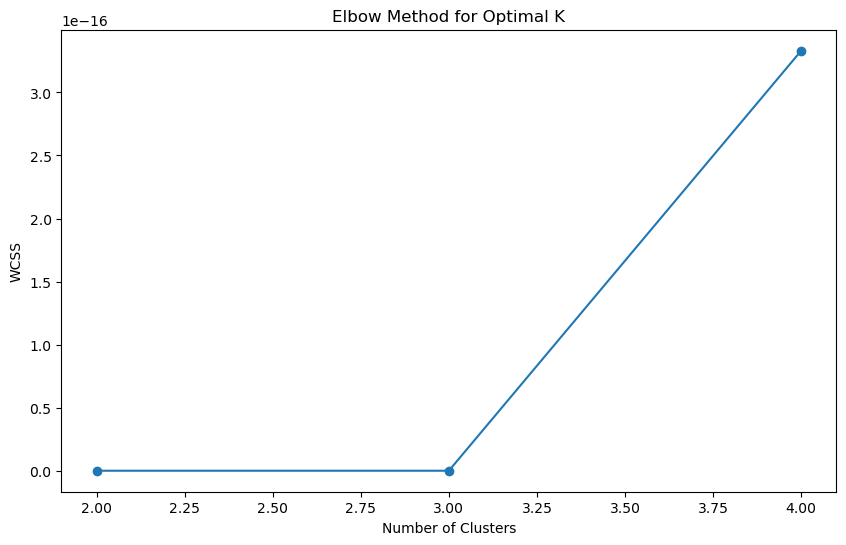

In [35]:
# Get the number of samples
num_samples_data = visitor_tfidf.shape[0]

# Define maximum possible clusters
max_clusters = min(10, num_samples_data)  # Ensure clusters do not exceed samples

# Elbow Method
wcss = []
for i in range(2, max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(visitor_tfidf)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2, max_clusters), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

# Determine optimal_k safely
optimal_k = min(4, num_samples)  # Ensure it does not exceed sample count

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
visitor_df_final['Cluster'] = kmeans.fit_predict(visitor_tfidf)


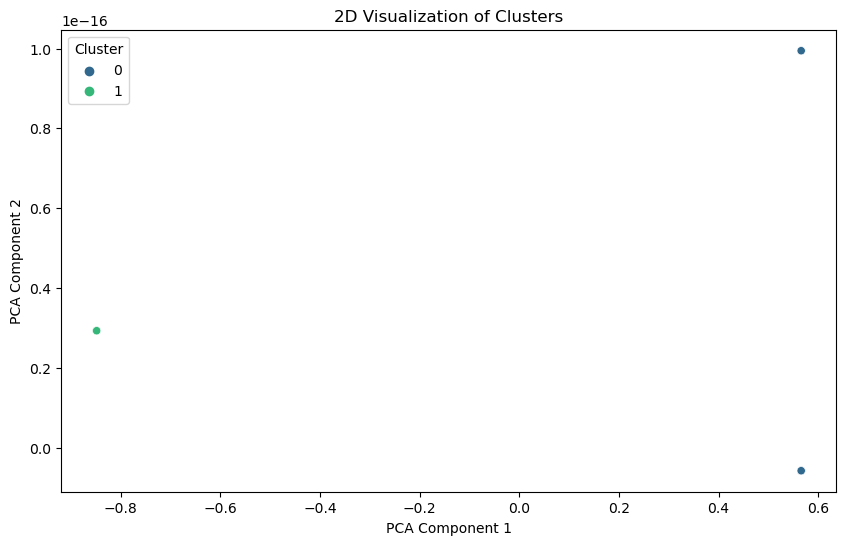

In [37]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(visitor_tfidf.toarray())

# Add reduced dimensions to DataFrame
visitor_df_final['PCA1'] = reduced_data[:, 0]
visitor_df_final['PCA2'] = reduced_data[:, 1]

# Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=visitor_df_final['PCA1'], y=visitor_df_final['PCA2'], hue=visitor_df_final['Cluster'], palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Visualization of Clusters")
plt.legend(title="Cluster")
plt.show()


#### Observation and insights
- New Categories Suggestion: Topics extracted from LDA can be used to propose new exhibitor categories based on visitor answer.

- Exhibitors can personalize their approach for different visitor clusters.

- The segmentation allows for a more efficient visitor-exhibitor recommendation system.